In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install -r https://raw.githubusercontent.com/abbbe/eye-on-stick/main/requirements.txt
    !git clone https://github.com/abbbe/eye-on-stick
    %cd eye-on-stick

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import os, urllib, time
import mlflow, git

from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.vec_env import VecNormalize
from stable_baselines import PPO2, SAC

import matplotlib.pyplot as plt
%matplotlib inline

from lib import eos
from lib.eos import EyeOnStickEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
from PIL import Image, ImageDraw
from IPython import display
from io import BytesIO

def showarray(img_array):
    buf = BytesIO()
    Image.fromarray(np.uint8(img_array)).save(buf, 'png')
    display.display(display.Image(data=buf.getvalue()))

In [4]:
with git.Repo() as repo:
    git_info = f'{repo.active_branch.name}/{repo.git.rev_parse(repo.head.object.hexsha, short=4)}'
    if repo.is_dirty():
        git_info = f'*{git_info}'

In [5]:
# we run N_ERAS eras (=mlflow runs), each era consists of N_STEPS steps
# at the end of each era we report metrics to mlflow and learn for N_LEARN_EPOCHS epochs
N_ERAS = 25 # eras 
N_STEPS = 1000 # steps each
N_LEARN_EPOCHS = 10000

N_ENVS = 1

params = {
        'REWARD_AIM_WEIGHT': 1,
        'REWARD_LEVEL_WEIGHT': 1,
        'REWARD_ACTION_WEIGHT': 0,
        'GEAR_FUNC_NOISE': 0
}

In [6]:
def run(n_joints, policy_class, model_name, N_ENVS=N_ENVS, name=None):
    env = make_vec_env(lambda: EyeOnStickEnv(n_joints, params), n_envs=N_ENVS)
    env = VecNormalize(env)
    
    run_name = f'{n_joints}J'
    if name is not None:
        run_name += f' {name}'

    with mlflow.start_run(run_name=run_name) as parent_run:
        # log params
        mlflow.log_param("policy_class", policy_class.__name__)
        mlflow.log_param("model_name", model_name)        
        for key, value in params.items():
            mlflow.log_param(key, value)

        # arrange tensorboard logs
        mlflow_artifacts_dir = urllib.request.url2pathname(urllib.parse.urlparse(mlflow.get_artifact_uri()).path)
        tensorboard_logdir = os.path.join(mlflow_artifacts_dir, "tensorboard_log")
        os.makedirs(tensorboard_logdir, exist_ok=False)

        model = policy_class(model_name, env, verbose=1, tensorboard_log=tensorboard_logdir)
        saved_models_dir = os.path.join(mlflow_artifacts_dir, "saved_models")
        os.makedirs(saved_models_dir, exist_ok=False)

        def log_run_metrics():
            mlflow.log_metric(key="alpha_mean", value=np.mean(all_alphas), step=era)
            mlflow.log_metric(key="alpha_std", value=np.std(all_alphas), step=era)
            mlflow.log_metric(key="eye_phi_mean", value=np.mean(all_eye_phis), step=era)
            mlflow.log_metric(key="eye_phi_std", value=np.std(all_eye_phis), step=era)
            mlflow.log_metric(key="reward_total", value=np.sum(all_rewards), step=era)
            mlflow.log_metric(key="reward_mean", value=np.mean(all_rewards), step=era)
            mlflow.log_metric(key="reward_std", value=np.std(all_rewards), step=era)

        for era in range(N_ERAS):
            all_alphas, all_eye_phis, all_rewards = [], [], []
            
            with mlflow.start_run(run_name=f'era={era}', nested=True) as child_run:
                if era > 0: # do not run simulation on freshly initialized model FIXME
                    obs = env.reset()
                    for _ in range(N_STEPS):
                        display.clear_output(wait=True)
                        showarray(env.render(mode='rgb_array'))
                        #import time
                        #time.sleep(.05)

                        actions, _ = model.predict(obs, deterministic=True)
                        obs, rewards, _dones, infos = env.step(actions)

                        all_alphas.append([info['alpha'] for info in infos])                
                        all_eye_phis.append([info['eye_phi'] for info in infos])                
                        all_rewards.append(rewards)

                    # log metrics into the child run
                    log_run_metrics()
                
                # learn, measure time it takes, and log it
                env.reset()
                start = time.perf_counter()
                model.learn(N_LEARN_EPOCHS)
                end = time.perf_counter()
                # log the mertics
                mlflow.log_metric(key="learning_time", value=(end-start), step=era)
                # save the trained models, each era separately
                model_fname = f'{saved_models_dir}/{era}'
                model.save(model_fname)
                
            # this should log to the parent run
            log_run_metrics()
                            
    env.close()

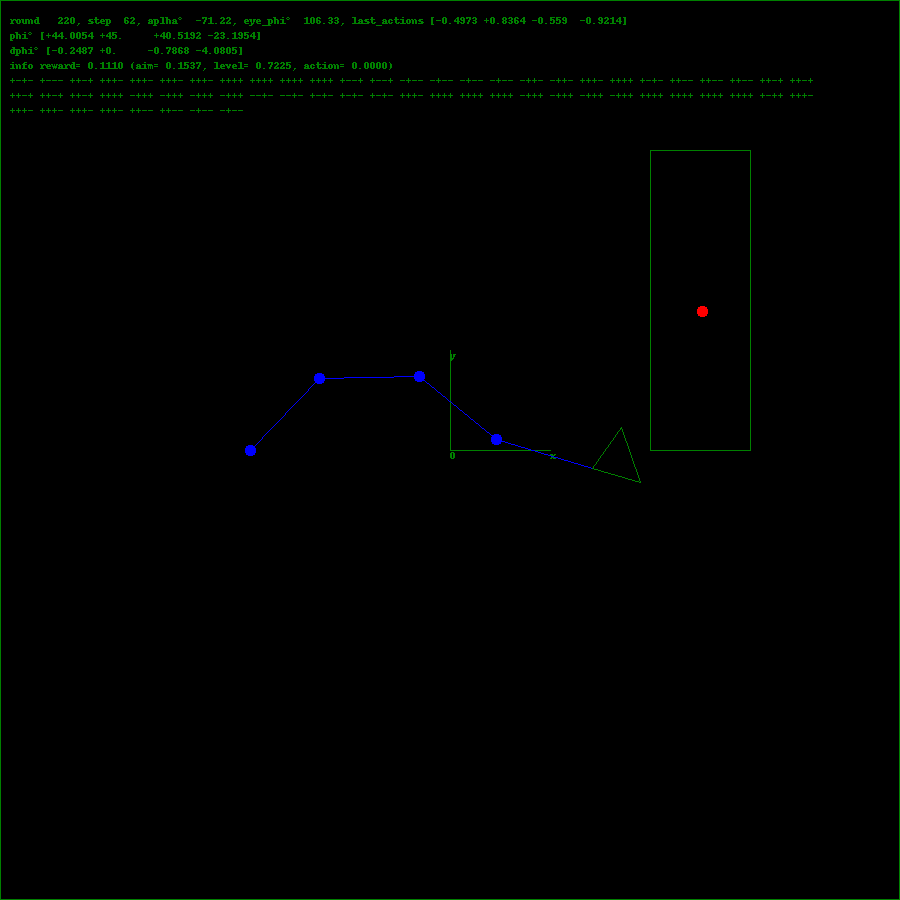

In [ ]:
for _ in range(5):
    run(n_joints=4, policy_class=SAC, model_name='MlpPolicy', name=git_info)